## Análise dos Dados

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# pega os nomes da estacoes
main_folder = "../data"
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

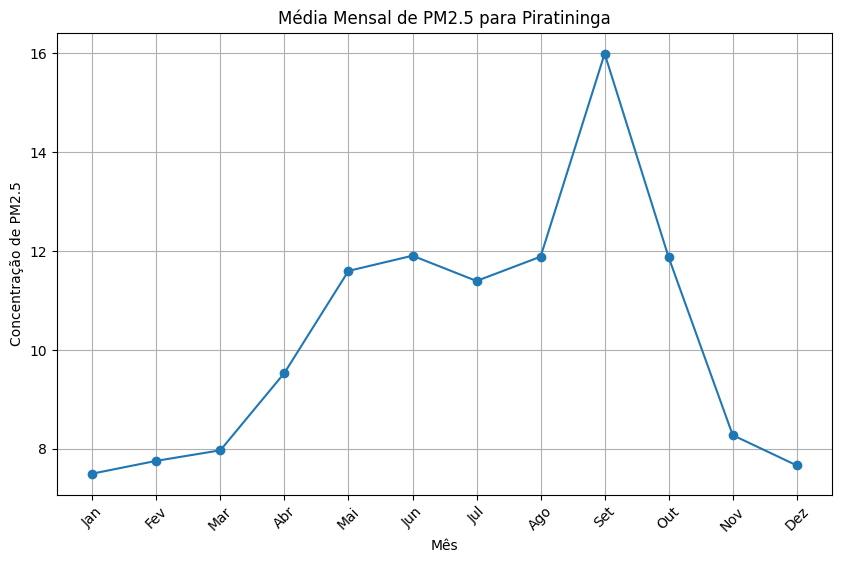

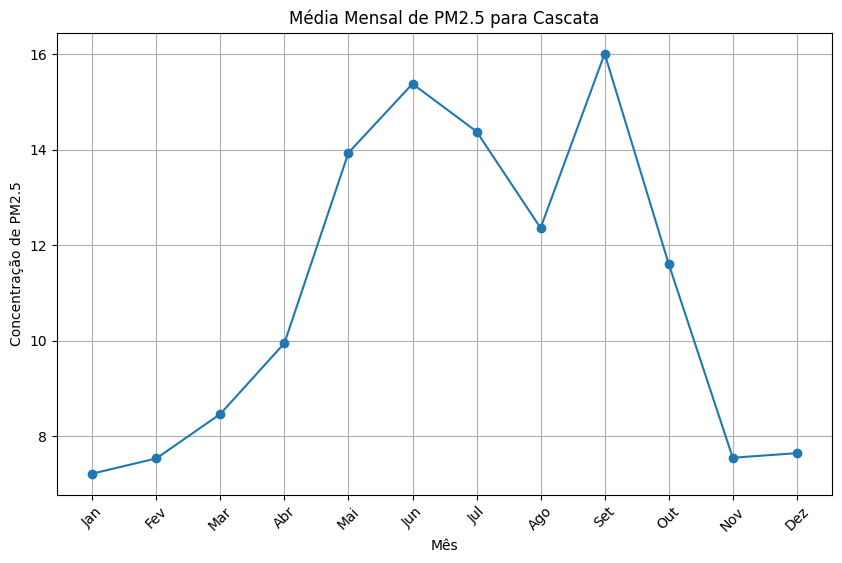

In [6]:
for station_folder in reversed(station_folders):
    combined_data = pd.read_csv(f"../dados_tratados/combinado/{station_folder}/{station_folder}_tratado_combinado.csv",
                                usecols=['Data e Hora', 'PM2.5'])
    combined_data['Data e Hora'] = pd.to_datetime(combined_data['Data e Hora'], format='%Y-%m-%d %H:%M:%S',
                                                  errors='coerce')

    # Cria uma coluna para o mês
    combined_data['Mes'] = combined_data['Data e Hora'].dt.month

    # Agrupa por mês e calcula a média de PM2.5
    monthly_avg_pm25 = combined_data.groupby('Mes')['PM2.5'].mean().reset_index()

    # Plotagem
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_avg_pm25['Mes'], monthly_avg_pm25['PM2.5'], marker='o', linestyle='-')
    plt.title(f'Média Mensal de PM2.5 para {station_folder}')
    plt.xlabel('Mês')
    plt.ylabel('Concentração de PM2.5')
    plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
               rotation=45)
    plt.grid(True)
    plt.show()

In [3]:
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define os nomes dos meses em português
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
         'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# Pega os nomes das estações
main_folder = "../data"
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

def plot_month(data, month, station):
    # Filtra os dados para o mês especificado
    month_data = data[data['Data e Hora'].dt.month == month]
    
    # Cria o gráfico
    fig = go.Figure()
    
    # Cores para cada semana
    colors = ['red', 'blue', 'green', 'purple']
    dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']
    
    for week in range(4):
        # Filtra os dados para a semana atual
        start_day = week * 7 + 1
        end_day = min(start_day + 6, month_data['Data e Hora'].dt.daysinmonth.iloc[0])
        week_data = month_data[(month_data['Data e Hora'].dt.day >= start_day) & 
                               (month_data['Data e Hora'].dt.day <= end_day)]
        
        # Agrupa por dia da semana e calcula a média de PM2.5
        weekly_avg = week_data.groupby(week_data['Data e Hora'].dt.dayofweek)['PM2.5'].mean().reindex(range(7))
        
        # Adiciona a linha para esta semana
        fig.add_trace(go.Scatter(x=dias_semana, y=weekly_avg, 
                                 mode='lines+markers', name=f'Semana {week+1}',
                                 line=dict(color=colors[week])))
    
    fig.update_layout(title=f'Média diária de PM2.5 em {meses[month-1]} - {station}',
                      xaxis_title='Dia da Semana',
                      yaxis_title='Concentração de PM2.5')
    
    return fig

for station_folder in station_folders:
    # Carrega os dados
    combined_data = pd.read_csv(f"../dados_tratados/combinado/{station_folder}/{station_folder}_tratado_combinado.csv",
                                usecols=['Data e Hora', 'PM2.5'])
    combined_data['Data e Hora'] = pd.to_datetime(combined_data['Data e Hora'], format='%Y-%m-%d %H:%M:%S',
                                                  errors='coerce')

    # Cria subplots para todos os meses
    fig = make_subplots(rows=4, cols=3, subplot_titles=meses)

    # Adiciona os gráficos para cada mês
    for month in range(1, 13):
        month_fig = plot_month(combined_data, month, station_folder)
        for trace in month_fig.data:
            fig.add_trace(trace, row=(month-1)//3 + 1, col=(month-1)%3 + 1)

    # Atualiza o layout
    fig.update_layout(height=1600, width=1200, title_text=f"Análise mensal de PM2.5 para {station_folder}")

    # Mostra o gráfico
    fig.show()

In [9]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

# pega os nomes das estações
main_folder = "../data"
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

def plot_time_series(data, station):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data['PM2.5'], mode='lines'))
    fig.update_layout(title=f'Série Temporal de PM2.5 para {station}',
                      xaxis_title='Data',
                      yaxis_title='Concentração de PM2.5')
    return fig

def plot_decomposition(data, station):
    # Preenche valores ausentes com interpolação linear
    data_filled = data['PM2.5'].interpolate(method='linear')
    
    # Verifica se há dados suficientes para decomposição
    if len(data_filled) < 730:  # Pelo menos 2 anos de dados diários
        print(f"Dados insuficientes para decomposição sazonal na estação {station}")
        return None
    
    # Decomposição da série temporal
    decomposition = seasonal_decompose(data_filled, model='additive', period=365)
    
    fig = make_subplots(rows=4, cols=1, subplot_titles=('Observado', 'Tendência', 'Sazonalidade', 'Resíduos'))
    fig.add_trace(go.Scatter(x=data.index, y=decomposition.observed, mode='lines'), row=1, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=decomposition.trend, mode='lines'), row=2, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=decomposition.seasonal, mode='lines'), row=3, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=decomposition.resid, mode='lines'), row=4, col=1)
    
    fig.update_layout(height=1000, title_text=f"Decomposição da Série Temporal de PM2.5 para {station}")
    return fig

def plot_heatmap(data, station):
    # Criando um DataFrame com ano, mês e média de PM2.5
    heatmap_data = data.groupby([data.index.year, data.index.month])['PM2.5'].mean().unstack()
    
    fig = px.imshow(heatmap_data,
                    labels=dict(x="Mês", y="Ano", color="PM2.5"),
                    x=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
                    y=heatmap_data.index)
    fig.update_layout(title=f'Heatmap de PM2.5 por Ano e Mês para {station}')
    return fig

def plot_monthly_boxplots(data, station):
    data['Month'] = data.index.month
    data['Year'] = data.index.year
    
    fig = px.box(data, x='Month', y='PM2.5', color='Year',
                 labels={'Month': 'Mês', 'PM2.5': 'Concentração de PM2.5'},
                 title=f'Boxplots Mensais de PM2.5 por Ano para {station}')
    fig.update_xaxes(tickvals=list(range(1, 13)),
                     ticktext=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    return fig

for station_folder in station_folders:
    # Carrega os dados
    combined_data = pd.read_csv(f"../dados_tratados/combinado/{station_folder}/{station_folder}_tratado_combinado.csv",
                                usecols=['Data e Hora', 'PM2.5'])
    combined_data['Data e Hora'] = pd.to_datetime(combined_data['Data e Hora'], format='%Y-%m-%d %H:%M:%S',
                                                  errors='coerce')
    combined_data.set_index('Data e Hora', inplace=True)
    combined_data = combined_data.resample('D').mean()  # Resample para médias diárias

    # Remove linhas com valores ausentes
    combined_data = combined_data.dropna()

    if combined_data.empty:
        print(f"Não há dados válidos para a estação {station_folder}")
        continue

    # Plotagem da série temporal
    fig_ts = plot_time_series(combined_data, station_folder)
    fig_ts.show()

    # Decomposição da série temporal
    fig_decomp = plot_decomposition(combined_data, station_folder)
    if fig_decomp:
        fig_decomp.show()

    # Heatmap
    fig_heatmap = plot_heatmap(combined_data, station_folder)
    fig_heatmap.show()

    # Boxplots mensais
    fig_boxplots = plot_monthly_boxplots(combined_data, station_folder)
    fig_boxplots.show()